In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines.plotting import add_at_risk_counts, plot_lifetimes
from lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test, proportional_hazard_test
from lifelines import CoxPHFitter
from lifelines import NelsonAalenFitter

In [11]:
# # Windows
# input_path = "E:\\deeplearning\\Hepatocarcinomes\\TCGA\\"
# out_path = input_path + "heatmap\\survival\\"
# Ubuntu
input_path = "/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/TCGA/"
out_path = input_path + "validation/survival/"

In [12]:
# # Windows
# clusters = pd.read_csv(input_path + 'heatmap\\sample_clusters_filtered-6_median_km_euclidean_3.csv', sep=',')
# os = pd.read_csv(input_path + 'processed\\Overall_Survival_legacy.txt', sep='\t')
# dfs = pd.read_csv(input_path + 'processed\\Disease_Free_Survival_legacy.txt', sep='\t')
# gender = pd.read_csv(input_path + 'processed\\Sex_legacy.txt', sep='\t')
# Ubuntu
clusters = pd.read_csv(input_path + 'validation/sample_clusters_full_raw_hc_cnmf_ordered_euclidean_3.csv', sep=',')
os = pd.read_csv(input_path + 'processed/Overall_Survival_legacy.txt', sep='\t')
dfs = pd.read_csv(input_path + 'processed/Disease_Free_Survival_legacy.txt', sep='\t')
gender = pd.read_csv(input_path + 'processed/Sex_legacy.txt', sep='\t')

In [13]:
print(clusters.shape) # (340, 2)
display(clusters.head(5))
print()
print(os.shape) # (340, 2)
display(os.head(5))
print()
print(dfs.shape) # (340, 2)
display(dfs.head(5))
print()
print(gender.shape) # (340, 2)
display(gender.head(5))
print()

(340, 2)


,Sample,Cluster
0,AAE1.01A,Cluster High
1,AAVX.01A,Cluster High
2,AACO.01A,Cluster High
3,A4NK.01A,Cluster High
4,AAE2.01A,Cluster High



(440, 4)


,Study ID,Patient ID,OS_STATUS,OS_MONTHS
0,lihc_tcga,TCGA-2V-A95S,0:LIVING,NaN
1,lihc_tcga,TCGA-2Y-A9GS,1:DECEASED,23.78
2,lihc_tcga,TCGA-2Y-A9GT,1:DECEASED,53.35
3,lihc_tcga,TCGA-2Y-A9GU,0:LIVING,63.70
4,lihc_tcga,TCGA-2Y-A9GV,1:DECEASED,83.18



(440, 4)


,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS
0,lihc_tcga,TCGA-2V-A95S,0:DiseaseFree,NaN
1,lihc_tcga,TCGA-2Y-A9GS,1:Recurred/Progressed,3.35
2,lihc_tcga,TCGA-2Y-A9GT,1:Recurred/Progressed,35.58
3,lihc_tcga,TCGA-2Y-A9GU,0:DiseaseFree,63.70
4,lihc_tcga,TCGA-2Y-A9GV,1:Recurred/Progressed,71.91



(377, 3)


,Study ID,Patient ID,Sex
0,lihc_tcga,TCGA-2V-A95S,Male
1,lihc_tcga,TCGA-2Y-A9GS,Male
2,lihc_tcga,TCGA-2Y-A9GT,Male
3,lihc_tcga,TCGA-2Y-A9GU,Female
4,lihc_tcga,TCGA-2Y-A9GV,Female


### Extract survival data

In [14]:
def exact_info(df, item):
    i=0
    clusters[item] = ''
    for sample in clusters["Sample"]:
        info = set(df[df['Patient ID'].str.contains(sample[:-4][-4:])][item])
        if len(info) != 1 :
#             raise ValueError('Multiple or no values found.')
            i=i+1
        else:
            info = list(info)[0]
            clusters.loc[clusters["Sample"]==sample, item] = info
    return i # count of samples not found

In [15]:
print(exact_info(df = os, item = 'OS_STATUS')) # 0
print(exact_info(df = os, item = 'OS_MONTHS')) # 0

0
0


In [16]:
print(exact_info(df = dfs, item = 'DFS_STATUS')) # 0
print(exact_info(df = dfs, item = 'DFS_MONTHS')) # 0

0
0


In [17]:
print(exact_info(df = gender, item = 'Sex')) # 0

0


In [18]:
print(clusters.shape) # (340, 6)
display(clusters.head(5))
print()

(340, 7)


,Sample,Cluster,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,Sex
0,AAE1.01A,Cluster High,0:LIVING,18.13,0:DiseaseFree,18.13,Male
1,AAVX.01A,Cluster High,0:LIVING,56.44,1:Recurred/Progressed,12.91,Male
2,AACO.01A,Cluster High,0:LIVING,61.63,1:Recurred/Progressed,15.74,Male
3,A4NK.01A,Cluster High,1:DECEASED,39.75,1:Recurred/Progressed,2.92,Female
4,AAE2.01A,Cluster High,0:LIVING,20.96,0:DiseaseFree,20.96,Male


### Preprocess

In [19]:
for i in range(len(clusters)):
    clusters.loc[i,'OS_STATUS'] = clusters.loc[i,'OS_STATUS'][0]
    try:
        clusters.loc[i,'DFS_STATUS'] = clusters.loc[i,'DFS_STATUS'][0]
    except:
        pass

In [20]:
display(clusters.dtypes)
clusters = clusters.astype({'OS_STATUS':'float64', 'OS_MONTHS':'float64', 'DFS_STATUS':'float64', 'DFS_MONTHS':'float64'})
display(clusters.dtypes)

Sample        object
Cluster       object
OS_STATUS     object
OS_MONTHS     object
DFS_STATUS    object
DFS_MONTHS    object
Sex           object
dtype: object

Sample         object
Cluster        object
OS_STATUS     float64
OS_MONTHS     float64
DFS_STATUS    float64
DFS_MONTHS    float64
Sex            object
dtype: object

In [21]:
print(clusters.shape) # (340, 6)
display(clusters.head(5))
print()

(340, 7)


,Sample,Cluster,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,Sex
0,AAE1.01A,Cluster High,0.0,18.13,0.0,18.13,Male
1,AAVX.01A,Cluster High,0.0,56.44,1.0,12.91,Male
2,AACO.01A,Cluster High,0.0,61.63,1.0,15.74,Male
3,A4NK.01A,Cluster High,1.0,39.75,1.0,2.92,Female
4,AAE2.01A,Cluster High,0.0,20.96,0.0,20.96,Male


In [22]:
# Export data
clusters.to_csv(input_path+"heatmap//consensus_survival_filtered-sangro_median_km_euclidean_3.csv",sep="\t", index=False)

### *ATTENTION!*

In [23]:
# Merge cluster 01 and cluster 03 manually
# clusters = clusters.replace("Cluster High", "Cluster High + Median")
# clusters = clusters.replace("Cluster Median", "Cluster High + Median")

### Explore data

In [24]:
# Misssing values
clusters.groupby(["Cluster"]).count()

,Sample,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,Sex
Cluster,,,,,,
Cluster High,93,93,93,85,85,93
Cluster Low,150,150,150,131,131,150
Cluster Median,97,97,96,81,80,97


In [25]:
# Only 1 missing data for OS, with OS_STATUS but no OS_MONTHS
clusters[clusters['OS_MONTHS'].isna()]

,Sample,Cluster,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,Sex
94,A95S.01A,Cluster Median,0.0,NaN,0.0,NaN,Male


In [26]:
# Censored values
clusters.groupby(["OS_STATUS"]).count()

,Sample,Cluster,OS_MONTHS,DFS_STATUS,DFS_MONTHS,Sex
OS_STATUS,,,,,,
0.0,220,220,219,220,219,220
1.0,120,120,120,77,77,120


## Overall survival

### Kaplan Meier for all patient

Median survival time: 58.84 months
Survival rate: 
12    0.827121
24    0.699969
36    0.632235
48    0.560653
60    0.488692
Name: All patients, dtype: float64


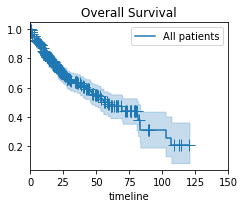

In [28]:
kmf = KaplanMeierFitter()
T = clusters.dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
E = clusters.dropna(subset = ["OS_MONTHS"])['OS_STATUS']
kmf.fit(T, event_observed=E, label="All patients")
plt.figure(figsize=(3.5, 3))
kmf.plot(show_censors=True, at_risk_counts=False)
plt.title("Overall Survival");
plt.xlim(0, 150)
plt.tight_layout()
plt.savefig(out_path+"os_all.png")
print("Median survival time: " + str(kmf.median_survival_time_) + " months")
print("Survival rate: ")
print(kmf.survival_function_at_times([12,24,36,48,60], label=None))

### Visualize censored values

In [19]:
# ax = plot_lifetimes(T, event_observed=E)
# # ax.set_xlim(0, 25)
# # ax.vlines(10, 0, 30, lw=2, linestyles='--')
# ax.set_xlabel("time")
# ax.set_title("Overall survival time")
# # print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

### Kaplan Meier by clusters

Median survival time: 83.18 months
Overall survival rates: 
12    0.943991
24    0.809880
36    0.784571
48    0.681528
60    0.620854
Name: Cluster High, dtype: float64
Median survival time: 55.65 months
Overall survival rates: 
12    0.838527
24    0.729799
36    0.691226
48    0.579901
60    0.483250
Name: Cluster Median, dtype: float64
Median survival time: 33.02 months
Overall survival rates: 
12    0.739915
24    0.601069
36    0.487659
48    0.464437
60    0.406147
Name: Cluster Low, dtype: float64


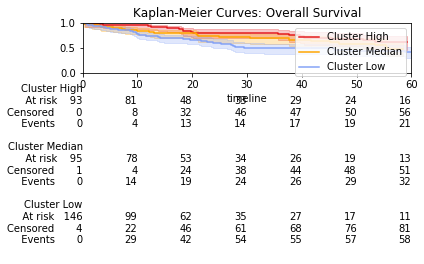

In [31]:
ax = plt.subplot(111)

kmf_os1 = KaplanMeierFitter()
f_os1 = clusters.Cluster == "Cluster High"
T_os1 = clusters[f_os1].dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
E_os1 = clusters[f_os1].dropna(subset = ["OS_MONTHS"])['OS_STATUS']
kmf_os1.fit(T_os1, event_observed=E_os1, label="Cluster High")
print("Median survival time: " + str(kmf_os1.median_survival_time_) + " months")
print("Overall survival rates: ")
print(kmf_os1.survival_function_at_times([12,24,36,48,60], label="Cluster High"))
ax = kmf_os1.plot(ax=ax, loc=slice(0, 60), color="#E41A1C" )

kmf_os2 = KaplanMeierFitter()
f_os2 = clusters.Cluster == "Cluster Median"
T_os2 = clusters[f_os2].dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
E_os2 = clusters[f_os2].dropna(subset = ["OS_MONTHS"])['OS_STATUS']
kmf_os2.fit(T_os2, event_observed=E_os2, label="Cluster Median")
print("Median survival time: " + str(kmf_os2.median_survival_time_) + " months")
print("Overall survival rates: ")
print(kmf_os2.survival_function_at_times([12,24,36,48,60], label="Cluster Median"))
ax = kmf_os2.plot(ax=ax, loc=slice(0, 60), color="#FFA500")

kmf_os3 = KaplanMeierFitter()
f_os3 = clusters.Cluster == "Cluster Low"
T_os3 = clusters[f_os3].dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
E_os3 = clusters[f_os3].dropna(subset = ["OS_MONTHS"])['OS_STATUS']
kmf_os3.fit(T_os3, event_observed=E_os3, label="Cluster Low")
print("Median survival time: " + str(kmf_os3.median_survival_time_) + " months")
print("Overall survival rates: ")
print(kmf_os3.survival_function_at_times([12,24,36,48,60], label="Cluster Low"))
ax = kmf_os3.plot(ax=ax, loc=slice(0, 60), color="#84a2f7")

# kmf_os4 = KaplanMeierFitter()
# f_os4 = clusters.Cluster == "Cluster 04"
# T_os4 = clusters[f_os4].dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
# E_os4 = clusters[f_os4].dropna(subset = ["OS_MONTHS"])['OS_STATUS']
# kmf_os4.fit(T_os4, event_observed=E_os4, label="Cluster 04")
# print("Median survival time: " + str(kmf_os4.median_survival_time_) + " months")
# print("Overall survival rates: ")
# print(kmf_os4.survival_function_at_times([12,24,36,48,60], label="Cluster 04"))
# ax = kmf_os4.plot(ax=ax, loc=slice(0, 60))

# kmf_os5 = KaplanMeierFitter()
# f_os5 = clusters.Cluster == "Cluster 05"
# T_os5 = clusters[f_os5].dropna(subset = ["OS_MONTHS"])['OS_MONTHS']
# E_os5 = clusters[f_os5].dropna(subset = ["OS_MONTHS"])['OS_STATUS']
# kmf_os5.fit(T_os5, event_observed=E_os5, label="Cluster 05")
# print("Median survival time: " + str(kmf_os4.median_survival_time_) + " months")
# print("Overall survival rates: ")
# print(kmf_os5.survival_function_at_times([12,24,36,48,60], label="Cluster 05"))
# ax = kmf_os5.plot(ax=ax, loc=slice(0, 60))

plt.ylim(0, 1)
plt.xlim(0, 60)
plt.title("Kaplan-Meier Curves: Overall Survival")
plt.tight_layout()
plt.savefig(out_path+"os.png")

# add_at_risk_counts(kmf_os1, kmf_os3, ax=ax)
add_at_risk_counts(kmf_os1, kmf_os2, kmf_os3, ax=ax)

### Log-rank test

In [32]:
# Generalized
result = multivariate_logrank_test(T, clusters.dropna(subset = ["OS_MONTHS"])["Cluster"], E, t_0 = 60, strata="Sex",weightings="peto")
result.print_summary()

<lifelines.StatisticalResult: multivariate_Peto_test>
               t_0 = 60
 null_distribution = chi squared
degrees_of_freedom = 2
            strata = Sex
         test_name = multivariate_Peto_test

---
 test_statistic    p  -log2(p)
           9.33 0.01      6.73

In [33]:
# Pairwise
result = pairwise_logrank_test(T, clusters.dropna(subset = ["OS_MONTHS"])["Cluster"], E, t_0 = 60, strata="Sex", weightings="peto")
result.print_summary()

<lifelines.StatisticalResult: Peto_test>
               t_0 = 60
 null_distribution = chi squared
degrees_of_freedom = 1
            strata = Sex
         test_name = Peto_test

---
                             test_statistic      p  -log2(p)
Cluster High Cluster Low               9.07 <0.005      8.59
             Cluster Median            2.24   0.13      2.89
Cluster Low  Cluster Median            2.12   0.15      2.78

### Cox proportional hazards regression model

#### One-hot encoding

In [23]:
# # Convert cluster to one-hot encoding
# clusters_dummy = pd.get_dummies(clusters.dropna(subset = ["OS_MONTHS"])["Cluster"])
# clusters_dummy = pd.concat([clusters_dummy,T],axis=1)
# clusters_dummy = pd.concat([clusters_dummy,E],axis=1)
# print(clusters_dummy.shape)
# clusters_dummy.head(5)

In [24]:
# # To use cox model, at least drop one of the converted col
# clusters_dummy.drop(columns=["Cluster 02"], inplace=True)

In [25]:
# # Using Cox Proportional Hazards model
# cph = CoxPHFitter()   ## Instantiate the class to create a cph object
# print(cph.fit(clusters_dummy, "OS_MONTHS", "OS_STATUS"))   ## Fit the data to train the model
# cph.print_summary()    ## HAve a look at the significance of the features

#### Ordered integer colomn

In [26]:
# # Order the clusters: higher values means higher expression.
# clusters_dummy = clusters.dropna(subset = ["OS_MONTHS"]).reset_index(drop=True).filter(items=["Cluster","OS_STATUS","OS_MONTHS"])
# for i in range(len(clusters_dummy)):
#     c = int(clusters_dummy["Cluster"][i][-1])
#     if c == 1:
#         c = 2
#     elif c == 2:
#         c = 1
#     clusters_dummy.loc[i, "Cluster"] = c
# print(clusters_dummy.shape)
# clusters_dummy.head(5)

In [27]:
# # Using Cox Proportional Hazards model without on hot encoding
# cph = CoxPHFitter()   ## Instantiate the class to create a cph object
# print(cph.fit(clusters_dummy, "OS_MONTHS", "OS_STATUS"))   ## Fit the data to train the model
# cph.print_summary()    ## HAve a look at the significance of the features

In [28]:
# # Check if the proprtional hazards assuption is violated
# cph.check_assumptions(clusters_dummy, show_plots=True)

### Nelson-Aalen estimate for the cumulative hazard

In [29]:
# naf = NelsonAalenFitter()

# naf.fit(T_os1, event_observed=E_os1, label="Cluster 01")
# # ax = naf.plot(loc=slice(0, 70))
# ax = naf.plot()

# naf.fit(T_os2, event_observed=E_os2, label="Cluster 02")
# # naf.plot(ax=ax, loc=slice(0, 70))
# ax = naf.plot()

# naf.fit(T_os3, event_observed=E_os3, label="Cluster 03")
# # naf.plot(ax=ax, loc=slice(0, 70))
# ax = naf.plot()

# plt.title("Cumulative Hazard Function: Overall Survival");
# # plt.ylim(0, 0.4)
# # plt.xlim(0, 125);
# ax.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig(out_path+"os_cumulative_hazard.png")

In [30]:
# naf = NelsonAalenFitter()
# bandwidth = 3

# naf.fit(T_os1, event_observed=E_os1, label="Cluster 01")
# ax = naf.plot(loc=slice(0, 60))
# # ax = naf.plot()

# naf.fit(T_os2, event_observed=E_os2, label="Cluster 02")
# naf.plot(ax=ax, loc=slice(0, 60))
# # ax = naf.plot()

# # naf.fit(T_os3, event_observed=E_os3, label="Cluster 03")
# # naf.plot(ax=ax, loc=slice(0, 60))
# # # ax = naf.plot()

# # naf.fit(T_os4, event_observed=E_os4, label="Cluster 04")
# # naf.plot(ax=ax, loc=slice(0, 60))
# # # ax = naf.plot()

# # naf.fit(T_os5, event_observed=E_os5, label="Cluster 05")
# # naf.plot(ax=ax, loc=slice(0, 60))
# # # ax = naf.plot()

# plt.title("Cumulative Hazard Function: Overall Survival");
# # plt.ylim(0, 0.4)
# plt.xlim(0, 60);
# ax.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig(out_path+"os_cumulative_hazard_60.png")

## Disease free survival

### Kaplan Meier plot for all patients

Median survival time: 20.99 months
Survival rate: 
12    0.649949
24    0.464015
36    0.388957
48    0.326577
60    0.293714
Name: All patients, dtype: float64


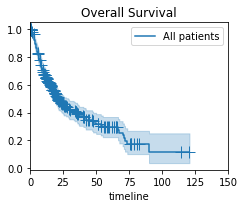

In [34]:
kmf = KaplanMeierFitter()
T_dfs = clusters.dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS']
E_dfs = clusters.dropna(subset = ["DFS_MONTHS"])['DFS_STATUS']
kmf.fit(T_dfs, event_observed=E_dfs, label="All patients")
plt.figure(figsize=(3.5, 3))
kmf.plot(show_censors=True, at_risk_counts=False)
plt.title("Overall Survival");
plt.xlim(0, 150)
plt.tight_layout()
plt.savefig(out_path+"dfs_all.png")
print("Median survival time: " + str(kmf.median_survival_time_) + " months")
print("Survival rate: ")
print(kmf.survival_function_at_times([12,24,36,48,60], label=None))

### Kaplan Meier plot by clusters

Median survival time: 25.49 months
Disease free survival rates: 
12    0.804899
24    0.548064
36    0.439624
48    0.405807
60    0.365226
Name: Cluster High, dtype: float64
Median survival time: 35.58 months
Disease free urvival rates: 
12    0.726601
24    0.586041
36    0.471506
48    0.381365
60    0.346695
Name: Cluster Median, dtype: float64
Median survival time: 11.79 months
Disease free urvival rates: 
12    0.491517
24    0.321227
36    0.290634
48    0.232092
60    0.203081
Name: Cluster Low, dtype: float64


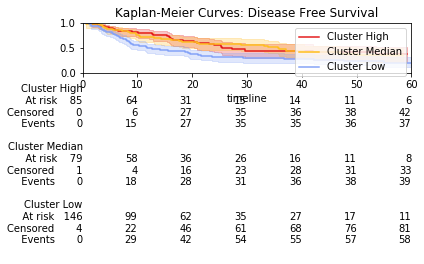

In [37]:
ax = plt.subplot(111)

kmf_dfs1 = KaplanMeierFitter()
f_dfs1 = clusters.Cluster == "Cluster High"
T_dfs1 = clusters[f_dfs1].dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS']
E_dfs1 = clusters[f_dfs1].dropna(subset = ["DFS_MONTHS"])['DFS_STATUS']
kmf_dfs1.fit(T_dfs1, event_observed=E_dfs1, label="Cluster High")
print("Median survival time: " + str(kmf_dfs1.median_survival_time_) + " months")
print("Disease free survival rates: ")
print(kmf_dfs1.survival_function_at_times([12,24,36,48,60], label="Cluster High"))
ax = kmf_dfs1.plot(ax=ax, loc=slice(0, 60),color="#E41A1C")

kmf_dfs2 = KaplanMeierFitter()
f_dfs2 = clusters.Cluster == "Cluster Median"
T_dfs2 = clusters[f_dfs2].dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS']
E_dfs2 = clusters[f_dfs2].dropna(subset = ["DFS_MONTHS"])['DFS_STATUS']
kmf_dfs2.fit(T_dfs2, event_observed=E_dfs2, label="Cluster Median")
print("Median survival time: " + str(kmf_dfs2.median_survival_time_) + " months")
print("Disease free urvival rates: ")
print(kmf_dfs2.survival_function_at_times([12,24,36,48,60], label="Cluster Median"))
ax = kmf_dfs2.plot(ax=ax, loc=slice(0, 60),color="#FFBE20")

kmf_dfs3 = KaplanMeierFitter()
f_dfs3 = clusters.Cluster == "Cluster Low"
T_dfs3 = clusters[f_dfs3].dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS']
E_dfs3 = clusters[f_dfs3].dropna(subset = ["DFS_MONTHS"])['DFS_STATUS']
kmf_dfs3.fit(T_dfs3, event_observed=E_dfs3, label="Cluster Low")
print("Median survival time: " + str(kmf_dfs3.median_survival_time_) + " months")
print("Disease free urvival rates: ")
print(kmf_dfs3.survival_function_at_times([12,24,36,48,60], label="Cluster Low"))
ax = kmf_dfs3.plot(ax=ax, loc=slice(0, 60),color="#84a2f7")

# kmf_dfs4 = KaplanMeierFitter()
# f_dfs4 = clusters.Cluster == "Cluster 04"
# T_dfs4 = clusters[f_dfs4].dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS']
# E_dfs4 = clusters[f_dfs4].dropna(subset = ["DFS_MONTHS"])['DFS_STATUS']
# kmf_dfs4.fit(T_dfs4, event_observed=E_dfs4, label="Cluster 04")
# print("Median survival time: " + str(kmf_dfs4.median_survival_time_) + " months")
# print("Disease free urvival rates: ")
# print(kmf_dfs4.survival_function_at_times([12,24,36,48,60], label="Cluster 04"))
# ax = kmf_dfs4.plot(ax=ax, loc=slice(0, 60))

plt.ylim(0, 1)
plt.xlim(0, 60)
plt.title("Kaplan-Meier Curves: Disease Free Survival");
plt.tight_layout()
plt.savefig(out_path+"dfs.png")

# add_at_risk_counts(kmf_dfs1, kmf_dfs3, ax=ax)
add_at_risk_counts(kmf_dfs1, kmf_dfs2, kmf_os3, ax=ax)

### Log-rank test

In [38]:
# Generalized
# result = multivariate_logrank_test(clusters.dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS'], clusters.dropna(subset = ["DFS_MONTHS"])["Cluster"], clusters.dropna(subset = ["DFS_MONTHS"])['DFS_STATUS'], t_0=70)
result = multivariate_logrank_test(T_dfs, clusters.dropna(subset = ["DFS_MONTHS"])["Cluster"], E_dfs, t_0 = 60, strata="Sex", weightings="peto")
result.print_summary()

<lifelines.StatisticalResult: multivariate_Peto_test>
               t_0 = 60
 null_distribution = chi squared
degrees_of_freedom = 2
            strata = Sex
         test_name = multivariate_Peto_test

---
 test_statistic      p  -log2(p)
          16.69 <0.005     12.04

In [39]:
# pairwise
# result = pairwise_logrank_test(clusters.dropna(subset = ["DFS_MONTHS"])['DFS_MONTHS'], clusters.dropna(subset = ["DFS_MONTHS"])["Cluster"], clusters.dropna(subset = ["DFS_MONTHS"])['DFS_STATUS'], t_0=70)
result = pairwise_logrank_test(T_dfs, clusters.dropna(subset = ["DFS_MONTHS"])["Cluster"], E_dfs, t_0 = 60, strata="Sex", weightings="peto")
result.print_summary()

<lifelines.StatisticalResult: Peto_test>
               t_0 = 60
 null_distribution = chi squared
degrees_of_freedom = 1
            strata = Sex
         test_name = Peto_test

---
                             test_statistic      p  -log2(p)
Cluster High Cluster Low              12.59 <0.005     11.33
             Cluster Median            0.13   0.72      0.47
Cluster Low  Cluster Median            8.55 <0.005      8.18

### Cox proportional hazards regression model

#### One-hot encoding

In [35]:
# # Convert cluster to one-hot encoding
# clusters_dummy = pd.get_dummies(clusters.dropna(subset = ["DFS_MONTHS"])["Cluster"])
# clusters_dummy = pd.concat([clusters_dummy, T_dfs],axis=1)
# clusters_dummy = pd.concat([clusters_dummy, E_dfs],axis=1)
# print(clusters_dummy.shape)
# clusters_dummy.head(5)

In [36]:
# # To use cox model, at least drop one of the converted col
# clusters_dummy.drop(columns=["Cluster 03"], inplace=True)

In [37]:
# # Using Cox Proportional Hazards model
# cph = CoxPHFitter()   ## Instantiate the class to create a cph object
# print(cph.fit(clusters_dummy, "DFS_MONTHS", "DFS_STATUS"))   ## Fit the data to train the model
# cph.print_summary()    ## HAve a look at the significance of the features

#### Ordered integer colomn

In [38]:
# # Order the clusters: higher values means higher expression.
# clusters_dummy = clusters.dropna(subset = ["DFS_MONTHS"]).reset_index(drop=True).filter(items=["Cluster","DFS_STATUS","DFS_MONTHS"])
# for i in range(len(clusters_dummy)):
#     c = int(clusters_dummy["Cluster"][i][-1])
#     if c == 1:
#         c = 2
#     elif c == 2:
#         c = 1
#     clusters_dummy.loc[i, "Cluster"] = c
# print(clusters_dummy.shape)
# clusters_dummy.head(5)

In [39]:
# # Using Cox Proportional Hazards model without on hot encoding
# cph = CoxPHFitter()   ## Instantiate the class to create a cph object
# print(cph.fit(clusters_dummy, "DFS_MONTHS", "DFS_STATUS"))   ## Fit the data to train the model
# cph.print_summary()    ## HAve a look at the significance of the features

In [40]:
# # Check if the proprtional hazards assuption is violated
# cph.check_assumptions(clusters_dummy,show_plots=True)

In [41]:
# naf = NelsonAalenFitter()
# bandwidth = 3

# naf.fit(T_dfs1, event_observed=E_dfs1, label="Cluster 01")
# # ax = naf.plot(loc=slice(0, 70))
# ax = naf.plot()

# naf.fit(T_dfs2, event_observed=E_dfs2, label="Cluster 02")
# # naf.plot(ax=ax, loc=slice(0, 70))
# ax = naf.plot()

# naf.fit(T_dfs3, event_observed=E_dfs3, label="Cluster 03")
# # naf.plot(ax=ax, loc=slice(0, 70))
# ax = naf.plot()

# plt.title("Cumulative Hazard Function: Disease Free Survival");
# # plt.ylim(0, 0.4)
# # plt.xlim(0, 125);
# ax.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig(out_path+"dfs_cumulative_hazard.png")

In [42]:
# naf = NelsonAalenFitter()
# bandwidth = 3

# naf.fit(T_dfs1, event_observed=E_dfs1, label="Cluster 01")
# ax = naf.plot(loc=slice(0, 60))
# # ax = naf.plot()

# naf.fit(T_dfs2, event_observed=E_dfs2, label="Cluster 02")
# naf.plot(ax=ax, loc=slice(0, 60))
# # ax = naf.plot()

# # naf.fit(T_dfs3, event_observed=E_dfs3, label="Cluster 03")
# # naf.plot(ax=ax, loc=slice(0, 60))
# # # ax = naf.plot()

# # naf.fit(T_dfs4, event_observed=E_dfs4, label="Cluster 04")
# # naf.plot(ax=ax, loc=slice(0, 60))
# # # ax = naf.plot()

# plt.title("Cumulative Hazard Function: Disease Free Survival");
# # plt.ylim(0, 0.4)
# plt.xlim(0, 60);
# ax.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig(out_path+"dfs_cumulative_hazard_60.png")